# Homework assignments (For who needs an exam grade)

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision  #to get the MNIST dataset


import numpy as np
import matplotlib.pyplot as plt

1. Maybe normalise from 0 to 1 instead of 255?
2. Should you normalize the input?
2. Resize the image?
2. Convert to classes 1..30
2. Dropout
3. Which pooling layer? - mean because of color (what paddding to use?)


## Scetch of the above points:

1. MODEL: Which architecture do you consider the most appropriate for this task, and why;

The most appriopriate architecture for this tack would be Convolutional Neural Network, as it uses the information about values location on a 2D plane. As the dataset consist of pictures, using architecture that can use more complex information about pixel location in relation to each other can be benefitial.

2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;

The input of a model is a pair of a image transformed to a tensor and a target class. As in classification tasks we typically use no. of neurons in the output layer equal to no. of classes, I assigned number from 0 to 29 to each unique pair (C1,C2) and used it as a target.

3. OUTPUT: How would you design the output layer and why;

No. of neurons in the output layer is equal to no. of classes. Higher activation of the neuron with the index i means, that the picture fed to the neural network belongs to the class i with a higher probability.

4. LOSS: Which loss function would you use to train your model and why;

I use nn.CrossEntropyLoss(), as it is a loss for multiclass calssification. When using cross entropy loss, we do not have to apply activation to the output, as cross entropy loss is equivalent to using log softmax and then NLL loss.


5. MODEL CONFIGURATION:

 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)

I would use typical CNN architecture, meaning a sequence of Conv2D layers (for features extraction from data on 2D plane) followed by a polling layer (to lower the dimension and prevent overfitting). I use max pooling at is is widely regarder as superior to average pooling for classification tasks. Aftrer that, some fully connected layers to linearly project the tensors to the output of size 30. Before each fc layer dropout can be used for regularization purposes.

6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?

I would feed the model new examples and evaluate the output using appropriate loss function. As in this case one class id in fact correspond to two different qualities that can be classified, during evaluation process I could compute acccuracy for C1 and C2 seperately, as well as for my class ids.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/DLS/
%ls

Mounted at /content/drive
/content/drive/MyDrive/DLS
input.pkl


In [6]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")
print(f"C1 values: {np.unique(C1)}")
print(f"C2 values: {np.unique(C2)}")

length image:510
length C1:510
length C2:510
C1 values: ['dress' 'pants' 'shirt' 'shoes' 'shorts']
C2 values: ['black' 'blue' 'brown' 'green' 'red' 'white']


In [7]:
# create a dict that for each (C1,C2) pair assignes a class id (from 0 to 29)
class_dict = {}

n=0
for i in np.unique(C1):
  for j in np.unique(C2):
    class_dict[(i,j)] = n
    n += 1

print(class_dict)

{('dress', 'black'): 0, ('dress', 'blue'): 1, ('dress', 'brown'): 2, ('dress', 'green'): 3, ('dress', 'red'): 4, ('dress', 'white'): 5, ('pants', 'black'): 6, ('pants', 'blue'): 7, ('pants', 'brown'): 8, ('pants', 'green'): 9, ('pants', 'red'): 10, ('pants', 'white'): 11, ('shirt', 'black'): 12, ('shirt', 'blue'): 13, ('shirt', 'brown'): 14, ('shirt', 'green'): 15, ('shirt', 'red'): 16, ('shirt', 'white'): 17, ('shoes', 'black'): 18, ('shoes', 'blue'): 19, ('shoes', 'brown'): 20, ('shoes', 'green'): 21, ('shoes', 'red'): 22, ('shoes', 'white'): 23, ('shorts', 'black'): 24, ('shorts', 'blue'): 25, ('shorts', 'brown'): 26, ('shorts', 'green'): 27, ('shorts', 'red'): 28, ('shorts', 'white'): 29}


In [8]:
target_class = []
for i in range(len(images)):
  target_class.append(class_dict[(C1[i],C2[i])])
print(target_class)
print(np.unique(target_class))
print(f"out of 30 possible classes, {len(np.unique(target_class))} are present")

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,

In [9]:
#or output 5x6? - reshape to 5x6 at the end. But it doesnt change anythong really
# https://stackoverflow.com/questions/72420221/how-to-get-a-2d-output-from-linear-layer-in-pytorch
#or 5+6, then choose two with the highest probability -not necesserly makes sense

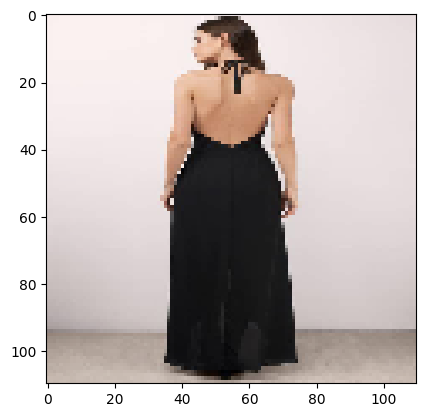

In [10]:
import cv2
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()

dress black


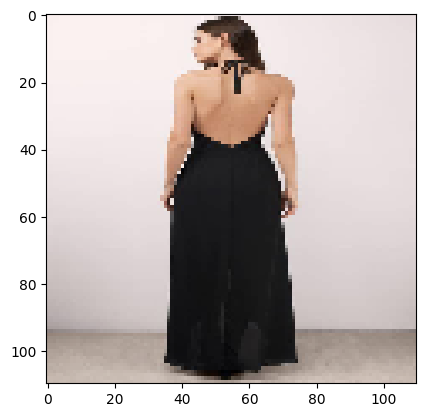

shirt black


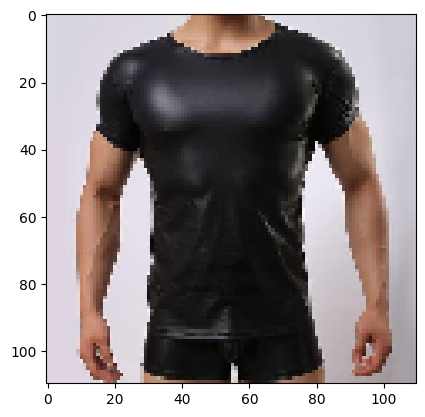

shorts black


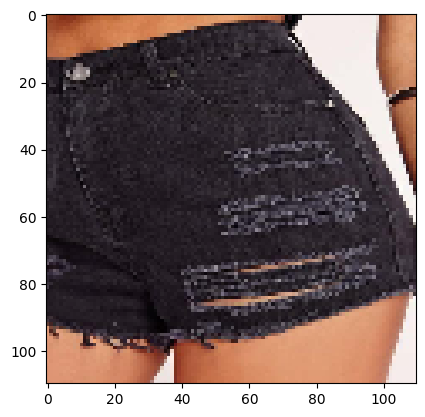

shirt blue


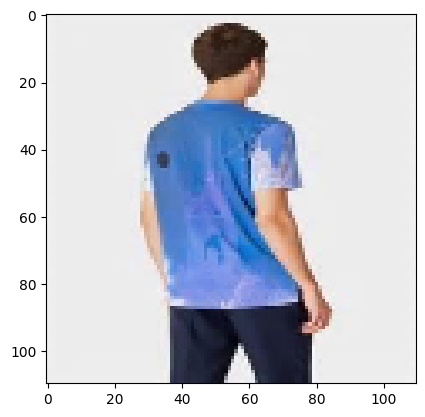

shorts blue


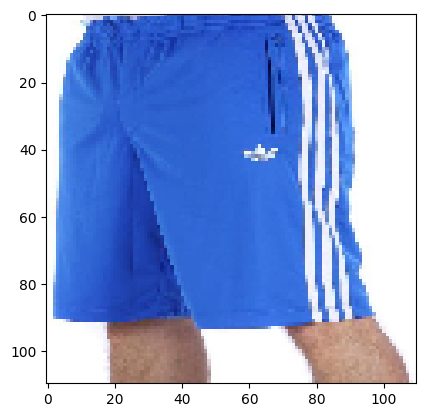

In [11]:
for i in range(5):
  plt.imshow(cv2.cvtColor(images[i*50], cv2.COLOR_BGR2RGB))
  print(C1[i*50], C2[i*50])
  plt.show()

# Implementing the model

In [12]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, 4)

        #output size  = 110 - 4 + 1 = 107

        self.conv2 = nn.Conv2d(50, 150, 4)
        #out size 107 - 4 + 1 = 104
        self.pool = nn.MaxPool2d(kernel_size=4)
        #out size (104 - 4)/4 + 1
        self.dropout1 = nn.Dropout()
        self.fc1 = nn.Linear(150*26*26, 200)
        self.dropout2 = nn.Dropout()
        self.fc2 = nn.Linear(200, 30)


    def forward(self, x):

      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.pool(x)
      x = self.dropout1(x)
      x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = self.dropout2(x)
      x = self.fc2(x)
      # x = F.log_softmax(x, dim=1)
      return x



In [13]:
#create dataset
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

class ImageDataset(Dataset):
    def __init__(self, img_labels, img_list, transform=None):
        self.img_labels = img_labels
        self.images = img_list
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

img_dataset = ImageDataset(target_class, images, transform=ToTensor())

train_set_size = int(0.7*len(img_dataset))
test_set_size = len(img_dataset) - train_set_size

train_set, test_set = random_split(img_dataset, [train_set_size, test_set_size])

val_set, test_set = random_split(test_set, [test_set_size//3, test_set_size-test_set_size//3])

print(val_set)
print(test_set)

In [14]:
# set dataloaders
batch_size = 20

train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set,
                                               batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_set,
                                              batch_size=batch_size,
                                              shuffle=False)

In [15]:
model = CNN()
print(model)

# check if model and dataloader work
it = iter(train_dataloader)
print(it)
X_batch, y_batch = next(it)
print(model.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(50, 150, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=101400, out_features=200, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=200, out_features=30, bias=True)
)
torch.Size([20, 30])


In [16]:
import torch
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
print(dev)
device = torch.device(dev)

cuda:0


In [17]:
def evaluate(model, test_loader, error):
    model.eval()
    correct = 0
    cur_loss = 0;

    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset)



#training the model
def fit(model, train_loader, error, test_loader, epochs, lr=0.0001):
    optimizer = torch.optim.Adam(model.parameters(),lr)


    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0;
        correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model(X_batch)
            loss = error(output, y_batch)
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, _ = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}')

    return train_losses, test_losses

In [18]:
epochs = 15
model = CNN().cuda()
# as log softmax was applied to the output, nll loss is used
# error = nn.NLLLoss()
error = nn.CrossEntropyLoss()
train_losses, test_losses = fit(model,train_dataloader, error, test_dataloader, epochs)

Epoch : 0,  train loss:0.16685648258326768, test loss:0.18121211435280593
Epoch : 1,  train loss:0.13415815716698057, test loss:0.15327995898676852
Epoch : 2,  train loss:0.09345305500244226, test loss:0.11378861642351337
Epoch : 3,  train loss:0.06075412352212003, test loss:0.11106207908368577
Epoch : 4,  train loss:0.03927896695644582, test loss:0.10660199324289958
Epoch : 5,  train loss:0.02265585946435688, test loss:0.10982819982603484
Epoch : 6,  train loss:0.013509761406427004, test loss:0.10582776163138595
Epoch : 7,  train loss:0.008972616527093892, test loss:0.12064687001938913
Epoch : 8,  train loss:0.005418337850260134, test loss:0.11991240814620373
Epoch : 9,  train loss:0.0035119102928651814, test loss:0.12536817380026274
Epoch : 10,  train loss:0.002561102827348295, test loss:0.13237091431430742
Epoch : 11,  train loss:0.0018049799771953363, test loss:0.1281382049999985
Epoch : 12,  train loss:0.0015438606425159786, test loss:0.13316901524861655
Epoch : 13,  train loss:0.

In [19]:
loss, acc = evaluate(model, val_dataloader, error)
print(f"Validation Accuracy:{acc}, Validation loss:{loss}")

Validation Accuracy:0.529411792755127, Validation loss:0.10444099061629351


## Maybe try checking object and color aspects of a class separately?

In [20]:
def evaluate_additonal(model, test_loader, error, target_dict):
    correct = 0
    cur_loss = 0
    corr_C1 = 0
    corr_C2 = 0
    model.eval()
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]

        for i in range(len(predicted)):
            pred_features = target_dict[int(predicted[i])]
            true_features = target_dict[int(test_labels[i])]
            corr_C1 += (pred_features[0] == true_features[0])
            corr_C2 += (pred_features[1] == true_features[1])

        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset), corr_C1/len(test_loader.dataset), corr_C2/len(test_loader.dataset)


target_to_features_dict = {v:k for k,v in class_dict.items()}
print(target_to_features_dict)
loss, acc, c1_acc, c2_acc = evaluate_additonal(model, val_dataloader, error, target_to_features_dict)
print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")

{0: ('dress', 'black'), 1: ('dress', 'blue'), 2: ('dress', 'brown'), 3: ('dress', 'green'), 4: ('dress', 'red'), 5: ('dress', 'white'), 6: ('pants', 'black'), 7: ('pants', 'blue'), 8: ('pants', 'brown'), 9: ('pants', 'green'), 10: ('pants', 'red'), 11: ('pants', 'white'), 12: ('shirt', 'black'), 13: ('shirt', 'blue'), 14: ('shirt', 'brown'), 15: ('shirt', 'green'), 16: ('shirt', 'red'), 17: ('shirt', 'white'), 18: ('shoes', 'black'), 19: ('shoes', 'blue'), 20: ('shoes', 'brown'), 21: ('shoes', 'green'), 22: ('shoes', 'red'), 23: ('shoes', 'white'), 24: ('shorts', 'black'), 25: ('shorts', 'blue'), 26: ('shorts', 'brown'), 27: ('shorts', 'green'), 28: ('shorts', 'red'), 29: ('shorts', 'white')}
Validation Accuracy:0.529411792755127, Validation loss:0.10444099061629351
Accuracy for C1:0.6862745098039216, Accuracy for C2:0.7647058823529411


In [21]:
def evaluate_additonal(model, test_loader, error, target_dict):
    correct = 0
    cur_loss = 0
    corr_C1 = 0
    corr_C2 = 0
    model.eval()
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]

        for i in range(len(predicted)):
            pred_features = target_dict[int(predicted[i])]
            true_features = target_dict[int(test_labels[i])]
            corr_C1 += (pred_features[0] == true_features[0])
            corr_C2 += (pred_features[1] == true_features[1])

        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset), corr_C1/len(test_loader.dataset), corr_C2/len(test_loader.dataset)


target_to_features_dict = {v:k for k,v in class_dict.items()}

## Trying out different CNNs, batch sizes, epochs and learning rates

In [22]:
learning_rates = [0.01,0.0001,0.000001]
epochs = [20, 30, 40]
batch_sizes = [10,30,50]

dataloaders = {s:{} for s in batch_sizes}

for batch_size in batch_sizes:

    dataloaders[batch_size]["train"] = torch.utils.data.DataLoader(train_set,
                                                batch_size=batch_size,
                                                shuffle=True)
    dataloaders[batch_size]["validation"] = torch.utils.data.DataLoader(val_set,
                                                batch_size=batch_size)
    dataloaders[batch_size]["test"] = torch.utils.data.DataLoader(test_set,
                                                batch_size=batch_size,
                                                shuffle=False)


In [23]:
def cnn_out_size(in_size, kernel_size, stride):
    return 1 + (in_size - kernel_size)//stride

class CNN_custom(nn.Module):

    def __init__(self, cnn_out_channels, cnn_kernel_sizes, cnn_strides, pooling_kernel, linear_hidden):
        super(CNN_custom, self).__init__()
        assert(len(cnn_out_channels)==len(cnn_kernel_sizes)==len(cnn_strides))
        sizes_out=[]
        conv_blocks = [nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=cnn_out_channels[0],
                kernel_size=cnn_kernel_sizes[0],
                stride = cnn_strides[0]),
            nn.ReLU()
        )]

        size_out = cnn_out_size(110, cnn_kernel_sizes[0], cnn_strides[0])
        sizes_out.append(size_out)
        for i in range(1, len(cnn_out_channels)):
            conv_blocks += [nn.Sequential(
                nn.Conv2d(
                    in_channels=cnn_out_channels[i-1],
                    out_channels=cnn_out_channels[i],
                    kernel_size=cnn_kernel_sizes[i],
                    stride=cnn_strides[i]),
                nn.ReLU())]

            size_out = cnn_out_size(size_out, cnn_kernel_sizes[i], cnn_strides[i])
            sizes_out.append(size_out)
        self.blocks = nn.ModuleList(conv_blocks)

        self.pool = nn.MaxPool2d(kernel_size=pooling_kernel)
        size_out = 1 + (size_out - pooling_kernel)//pooling_kernel
        sizes_out.append(size_out)
        self.dropout1 = nn.Dropout()
        self.fc1 = nn.Linear(size_out*size_out*cnn_out_channels[-1], linear_hidden)
        self.dropout2 = nn.Dropout()
        self.fc2 = nn.Linear(linear_hidden, 30)


    def forward(self, x):

        for block in self.blocks:
            x = block(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

epochs = 1
model = CNN_custom([30,80,80],[3,4,3],[2,2,1],8,80).cuda()
# as log softmax was applied to the output, nll loss is used
# error = nn.NLLLoss()
error = nn.CrossEntropyLoss()
train_losses, test_losses = fit(model,train_dataloader, error, test_dataloader, epochs)

Epoch : 0,  train loss:0.17149324443827824, test loss:0.19890581392774395


In [33]:
learning_rates = [0.01,0.0001,0.000001]
epochs = [20, 30, 40]
# epochs = [1, 2]
batch_sizes = [10,30,50]

dataloaders = {s:{} for s in batch_sizes}

for batch_size in batch_sizes:

    dataloaders[batch_size]["train"] = torch.utils.data.DataLoader(train_set,
                                                batch_size=batch_size,
                                                shuffle=True)
    dataloaders[batch_size]["validation"] = torch.utils.data.DataLoader(val_set,
                                                batch_size=batch_size)
    dataloaders[batch_size]["test"] = torch.utils.data.DataLoader(test_set,
                                                batch_size=batch_size,
                                                shuffle=False)

## Small grid search

In [34]:
models = [
    CNN_custom([30,80,80],[3,4,3],[2,2,1],8,80).cuda(),
    CNN_custom([60,200,100],[3,4,3],[3,4,2],3,300).cuda(),
    CNN_custom([60,200,100,50],[3,3,2,2],[3,3,2,1],4,150).cuda(),
    CNN_custom([60,100,100,80,40],[2,2,2,2,2],[1,1,1,1,1],3,150).cuda()
]

#[val_losses, val_acc, c1_acc,c2_acc]
results = []

model_idx = 0
for l_rate in learning_rates:
    for epoch_n in epochs:
        for batch_size in batch_sizes:
            model = models[model_idx]
            train_losses, test_losses = fit(model,dataloaders[batch_size]["train"], error, dataloaders[batch_size]["test"], epoch_n)
            print(f"l_rate {l_rate}, epoch_n {epoch_n}, batch_size {batch_size}, model {model_idx}")
            loss, acc, c1_acc, c2_acc = evaluate_additonal(model, dataloaders[batch_size]["validation"], error, target_to_features_dict)
            print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
            print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")
            results_dict = {"lr":l_rate, "epoch_n":epoch_n, "batch_size":batch_size, "model": model_idx}
            results_dict["eval"] = [loss, acc, c1_acc, c2_acc]
            results.append(results_dict)
            print(results)



Epoch : 0,  train loss:0.34286675800462396, test loss:0.36656420371111703
Epoch : 1,  train loss:0.3381288592554942, test loss:0.3604353479310578
Epoch : 2,  train loss:0.328138658646442, test loss:0.3569346409217984
Epoch : 3,  train loss:0.32041202339471553, test loss:0.35161638493631403
Epoch : 4,  train loss:0.3145409451813257, test loss:0.3409322476854511
Epoch : 5,  train loss:0.3045174100485836, test loss:0.3314111980737424
Epoch : 6,  train loss:0.29018683727381944, test loss:0.3109809580971213
Epoch : 7,  train loss:0.2637329709296133, test loss:0.2863005282832127
Epoch : 8,  train loss:0.23707846934054078, test loss:0.2647891862719667
Epoch : 9,  train loss:0.21581775167075193, test loss:0.24105823974983365
Epoch : 10,  train loss:0.19695010105101, test loss:0.2400776884135078
Epoch : 11,  train loss:0.18787894763198554, test loss:0.2493757313373042
Epoch : 12,  train loss:0.1717967022032965, test loss:0.22094394997054456
Epoch : 13,  train loss:0.1583092867159376, test loss:

In [35]:
model_idx = 1
for l_rate in learning_rates:
    for epoch_n in epochs:
        for batch_size in batch_sizes:
            model = models[model_idx]
            train_losses, test_losses = fit(model,dataloaders[batch_size]["train"], error, dataloaders[batch_size]["test"], epoch_n)
            print(f"l_rate {l_rate}, epoch_n {epoch_n}, batch_size {batch_size}, model {model_idx}")
            loss, acc, c1_acc, c2_acc = evaluate_additonal(model, dataloaders[batch_size]["validation"], error, target_to_features_dict)
            print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
            print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")
            results_dict = {"lr":l_rate, "epoch_n":epoch_n, "batch_size":batch_size, "model": model_idx}
            results_dict["eval"] = [loss, acc, c1_acc, c2_acc]
            results.append(results_dict)
            print(results)

Epoch : 0,  train loss:0.34054277524226856, test loss:0.3623965300765692
Epoch : 1,  train loss:0.33280133399642814, test loss:0.35328364605997126
Epoch : 2,  train loss:0.3247680744203199, test loss:0.35083629570755304
Epoch : 3,  train loss:0.32001059329142423, test loss:0.3481883839064953
Epoch : 4,  train loss:0.31610018532483186, test loss:0.3428065496332505
Epoch : 5,  train loss:0.30686796947019773, test loss:0.3256223996480306
Epoch : 6,  train loss:0.2908393668861282, test loss:0.31312038150488164
Epoch : 7,  train loss:0.27325408064684614, test loss:0.28889407597336114
Epoch : 8,  train loss:0.25745759958646547, test loss:0.28318725847730447
Epoch : 9,  train loss:0.23665520056289116, test loss:0.2558468323127896
Epoch : 10,  train loss:0.22040749497774267, test loss:0.250192989321316
Epoch : 11,  train loss:0.2085888823207353, test loss:0.23345986651439293
Epoch : 12,  train loss:0.19897143613724483, test loss:0.2297541242019803
Epoch : 13,  train loss:0.18332972913897005, t

In [36]:
model_idx = 2
for l_rate in learning_rates:
    for epoch_n in epochs:
        for batch_size in batch_sizes:
            model = models[model_idx]
            train_losses, test_losses = fit(model,dataloaders[batch_size]["train"], error, dataloaders[batch_size]["test"], epoch_n)
            print(f"l_rate {l_rate}, epoch_n {epoch_n}, batch_size {batch_size}, model {model_idx}")
            loss, acc, c1_acc, c2_acc = evaluate_additonal(model, dataloaders[batch_size]["validation"], error, target_to_features_dict)
            print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
            print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")
            results_dict = {"lr":l_rate, "epoch_n":epoch_n, "batch_size":batch_size, "model": model_idx}
            results_dict["eval"] = [loss, acc, c1_acc, c2_acc]
            results.append(results_dict)
            print(results)

Epoch : 0,  train loss:0.34241231950391243, test loss:0.36497001086964326
Epoch : 1,  train loss:0.34080898995492975, test loss:0.3624054777855967
Epoch : 2,  train loss:0.3353364120344488, test loss:0.35272911015678854
Epoch : 3,  train loss:0.3256549988808084, test loss:0.35006878189012114
Epoch : 4,  train loss:0.3197783816094492, test loss:0.35017017990935084
Epoch : 5,  train loss:0.31721360142491445, test loss:0.34499449823416917
Epoch : 6,  train loss:0.31401078306994185, test loss:0.34367990961261824
Epoch : 7,  train loss:0.30875122113054204, test loss:0.33612702874576345
Epoch : 8,  train loss:0.3008453552128554, test loss:0.3246966880910537
Epoch : 9,  train loss:0.2901507345568232, test loss:0.31337421781876507
Epoch : 10,  train loss:0.27642582511367586, test loss:0.3106030810113047
Epoch : 11,  train loss:0.26274642022717903, test loss:0.294777746294059
Epoch : 12,  train loss:0.25338181494330825, test loss:0.2920542113921222
Epoch : 13,  train loss:0.24585686377784452, t

In [37]:
model_idx = 3
for l_rate in learning_rates:
    for epoch_n in epochs:
        for batch_size in batch_sizes:
            model = models[model_idx]
            train_losses, test_losses = fit(model,dataloaders[batch_size]["train"], error, dataloaders[batch_size]["test"], epoch_n)
            print(f"l_rate {l_rate}, epoch_n {epoch_n}, batch_size {batch_size}, model {model_idx}")
            loss, acc, c1_acc, c2_acc = evaluate_additonal(model, dataloaders[batch_size]["validation"], error, target_to_features_dict)
            print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
            print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")
            results_dict = {"lr":l_rate, "epoch_n":epoch_n, "batch_size":batch_size, "model": model_idx}
            results_dict["eval"] = [loss, acc, c1_acc, c2_acc]
            results.append(results_dict)
            print(results)

Epoch : 0,  train loss:0.3386470570283778, test loss:0.3548765275992599
Epoch : 1,  train loss:0.31401357129842294, test loss:0.3217625430985993
Epoch : 2,  train loss:0.2643570485903102, test loss:0.2873876959669824
Epoch : 3,  train loss:0.23132319276740237, test loss:0.2784401552349913
Epoch : 4,  train loss:0.18048877208506695, test loss:0.26009077184340534
Epoch : 5,  train loss:0.1450707343112187, test loss:0.22859328167111265
Epoch : 6,  train loss:0.10386859719492808, test loss:0.2271262401459264
Epoch : 7,  train loss:0.08218199231711422, test loss:0.2189162677409602
Epoch : 8,  train loss:0.05104671777630387, test loss:0.27141913011962293
Epoch : 9,  train loss:0.049578237433393464, test loss:0.29676250733581244
Epoch : 10,  train loss:0.04175877366580215, test loss:0.26809557512694715
Epoch : 11,  train loss:0.023180220808301653, test loss:0.29724281325059776
Epoch : 12,  train loss:0.01872808024214179, test loss:0.34753458757026523
Epoch : 13,  train loss:0.0111575677902216

### Grid search results

In [38]:
for i, model in enumerate(models):
    print(f"MODEL {i}")
    print(model)

print("Grid search results")
for gd_result in results:
    print("="*50)
    print(f"l_rate {gd_result['lr']}, epoch_n {gd_result['epoch_n']}, batch_size {gd_result['batch_size']}, model_idx {gd_result['model']}")
    loss, acc, c1_acc, c2_acc = gd_result["eval"]
    print(f"Validation Accuracy:{acc}, Validation loss:{loss}")
    print(f"Accuracy for C1:{c1_acc}, Accuracy for C2:{c2_acc}")

MODEL 0
CNN_custom(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(30, 80, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
  )
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=80, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=80, out_features=30, bias=True)
)
MODEL 1
CNN_custom(
  (blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 60, kernel_size=(3, 3), stride=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(60, 200, kernel_size=(4, 4), stride=(4, 4))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(200, 100, kernel_size=(3, 3), stride=(2, 2))